In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.externals import joblib

from sklearn.utils import shuffle
sys.path.append( os.getcwd()+'/modules' )
import aux_functions

In [2]:
#Loading datasets
path = os.getcwd() 
os.chdir( "/home/toful/Documents/DataSets/cresci-2017.csv/datasets_full.csv/" )

real = pd.read_csv( 'genuine_accounts.csv/genuine_accounts.csv/users.csv' )
real = real.fillna( '' )
real['knownbot'] = 0

fakeFollowers = pd.read_csv('fake_followers.csv/fake_followers.csv/users.csv', na_filter=False)
fakeFollowers = fakeFollowers.fillna( '' )
fakeFollowers['knownbot'] = 1

socialSpamBots1 = pd.read_csv('social_spambots_1.csv/social_spambots_1.csv/users.csv', na_filter=False)
socialSpamBots1 = socialSpamBots1.fillna( '' )
socialSpamBots1['knownbot'] = 1

socialSpamBots2 = pd.read_csv('social_spambots_2.csv/social_spambots_2.csv/users.csv', na_filter=False)
socialSpamBots2 = socialSpamBots2.fillna( '' )
socialSpamBots2['knownbot'] = 1

socialSpamBots3 = pd.read_csv('social_spambots_3.csv/social_spambots_3.csv/users.csv', na_filter=False)
socialSpamBots3 = socialSpamBots3.fillna( '' )
socialSpamBots3['knownbot'] = 1

df_list = []

df_list += [ shuffle( pd.concat( [ real, fakeFollowers ], sort=False ) ) ]
df_list += [ shuffle( pd.concat( [ real, socialSpamBots1, socialSpamBots2, socialSpamBots3 ], sort=False ) ) ]
df_list += [ shuffle( pd.concat( [ real, fakeFollowers, socialSpamBots1, socialSpamBots2, socialSpamBots3 ], sort=False ) ) ]


os.chdir( path )


In [8]:
print len(real), len(fakeFollowers), len(socialSpamBots1)+len(socialSpamBots2)+len(socialSpamBots3)

 3474 3351 4912


In [3]:
df_list[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6825 entries, 1289 to 1642
Data columns (total 43 columns):
id                                    6825 non-null int64
name                                  6825 non-null object
screen_name                           6825 non-null object
statuses_count                        6825 non-null int64
followers_count                       6825 non-null int64
friends_count                         6825 non-null int64
favourites_count                      6825 non-null int64
listed_count                          6825 non-null int64
url                                   6825 non-null object
lang                                  6825 non-null object
time_zone                             6825 non-null object
location                              6825 non-null object
default_profile                       6825 non-null object
default_profile_image                 6825 non-null object
geo_enabled                           6825 non-null object
profile_ima

In [4]:
print( os.getcwd()  )

/home/toful/Dropbox/Uni/5e_Curs/TFG_I/BotDetector/src


In [3]:
#Building the working datasets
score_list = []
for df in df_list:
    score = pd.DataFrame()
    score['id'] = df['id']

    #score['lang-en'] = df.apply( lambda row: aux_functions.language (row), axis=1 )
    score['profile_pic'] = df.apply( lambda row: aux_functions.profile_image (row), axis=1 ) #check this feature
    score['def_profile_pic'] = df.apply( lambda row: aux_functions.def_profile_image (row), axis=1 )
    score['has_screen_name'] = df.apply( lambda row: aux_functions.screen_name (row), axis=1 )
    score['30followers'] = df.apply( lambda row: aux_functions.min_followers (row, 30), axis=1 )
    score['1000followers'] = df.apply( lambda row: aux_functions.min_followers2 (row, 1000), axis=1 )
    score['1000friends'] = df.apply( lambda row: aux_functions.min_friends (row, 1000), axis=1 )
    score['30friends'] = df.apply( lambda row: aux_functions.min_friends2 (row, 30), axis=1 )
    score['twice_num_followers'] = df.apply( lambda row: aux_functions.ratio_followers (row), axis=1 )
    score['fifty_FriendsFollowersRatio'] = df.apply( lambda row: aux_functions.ratio_followers2 (row, 50), axis=1 )
    score['hundred_FriendsFollowersRatio'] = df.apply( lambda row: aux_functions.ratio_followers2 (row, 100), axis=1 )
    score['geoloc'] = df.apply( lambda row: aux_functions.location (row), axis=1 )
    score['banner_link'] = df.apply( lambda row: aux_functions.profile_banner (row), axis=1 )
    score['50tweets'] = df.apply( lambda row: aux_functions.tweets_written (row, 50), axis=1 )
    score['20statuses'] = df.apply( lambda row: aux_functions.min_statuses (row, 20), axis=1 )
    score['NeverTweeted'] = df.apply( lambda row: aux_functions.never_tweeted (row ), axis=1 )
    score['has_description'] = df.apply( lambda row: aux_functions.description (row), axis=1 )
    score['knownbot'] = df.apply( lambda row: aux_functions.knownbot (row), axis=1 )

    print score.shape
    print score.describe()
    print score.columns.values
    score_list += [ score ]
    #score

(6825, 18)
                 id  profile_pic  def_profile_pic  has_screen_name  \
count  6.825000e+03       6825.0      6825.000000      6825.000000   
mean   8.499737e+08          0.0         0.002784         0.000147   
std    7.662248e+08          0.0         0.052693         0.012105   
min    6.780330e+05          0.0         0.000000         0.000000   
25%    2.597067e+08          0.0         0.000000         0.000000   
50%    6.168972e+08          0.0         0.000000         0.000000   
75%    1.174963e+09          0.0         0.000000         0.000000   
max    3.164942e+09          0.0         1.000000         1.000000   

       30followers  1000followers  1000friends    30friends  \
count  6825.000000    6825.000000  6825.000000  6825.000000   
mean      0.492601       0.105788     0.076337     0.024469   
std       0.499982       0.307588     0.265556     0.154511   
min       0.000000       0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000

# Data Analisis

In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [5]:
#Preparing the X and Y values for the machine learning analisis
yy=[]
XX=[]
for score in score_list:
    if 'knownbot' in score:
        y = score['knownbot'].values # get the labels we want
        X = score
        del X['knownbot']
        del X['id']
        X = X.values # use everything else to predict
        yy += [y]
        XX += [X]

In [8]:
for elem in score_list[0].columns.values:
    print elem

profile_pic
def_profile_pic
has_screen_name
30followers
1000followers
1000friends
30friends
twice_num_followers
fifty_FriendsFollowersRatio
hundred_FriendsFollowersRatio
geoloc
banner_link
50tweets
20statuses
NeverTweeted
has_description


# RF analysis

In [9]:
def train_model_v0( X, y, name ):
    num_cv_iterations = 3
    num_instances = len(y)
    cv_object = ShuffleSplit( n_splits=num_cv_iterations, test_size = 0.2 )

    # first we create a reusable logisitic regression and random forest objects
    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)

    iter_num=0
    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cv_object.split( X, y ):
        X_train = X[train_indices]
        y_train = y[train_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]

        # train the reusable logisitc regression model on the training data
        #lr_clf.fit( X_train, y_train ) # train object
        #y_pred = lr_clf.predict( X_test ) # get test set precitions

        rf_clf.fit( X_train, y_train ) # train object
        y_pred = rf_clf.predict( X_test ) # get test set precitions
        acc = mt.accuracy_score( y_test, y_pred )
        cmat = mt.confusion_matrix( y_test, y_pred )
        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        print "\n====Iteration",iter_num," ===="
        print "RANDOM FOREST"        
        print( mt.classification_report( y_test, y_pred ) )
        print "Accuracy Rate: ", acc
        print('Misclassification Rate: {}'.format( np.divide(np.sum( [ float(cmat[0,1]), float(cmat[1,0]) ] ), np.sum(cmat) ) ) )
        print('\nTP - True Negative {}'.format(cmat[0,0]))
        print('FP - False Positive {}'.format(cmat[0,1]))
        print('FN - False Negative {}'.format(cmat[1,0]))
        print('TP - True Positive {}'.format(cmat[1,1]))
        
        iter_num+=1

In [6]:
def train_model( X, y, name, n_estimators, max_depth, results, results2 ):
    num_cv_iterations = 3
    num_instances = len(y)
    cv_object = ShuffleSplit( n_splits=num_cv_iterations, test_size = 0.2 )

    # first we create a reusable logisitic regression and random forest objects
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
    
    glob_acc = 0
    glob_precision = 0
    glob_recall = 0
    glob_f1 = 0
    glob_miss = 0
    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cv_object.split( X, y ):
        X_train = X[train_indices]
        y_train = y[train_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]

        rf_clf.fit( X_train, y_train ) # train object
        y_pred = rf_clf.predict( X_test ) # get test set precitions
        
        acc = mt.accuracy_score( y_test, y_pred )
        precision,recall,fscore,support = mt.precision_recall_fscore_support(y_test, y_pred, average='weighted')
        cmat = mt.confusion_matrix( y_test, y_pred )
        miss= np.divide(np.sum( [ float(cmat[0,1]), float(cmat[1,0]) ] ), np.sum(cmat) )
        
        glob_acc += acc
        glob_precision += precision
        glob_recall += recall
        glob_f1 += fscore
        glob_miss += miss
    glob_acc = float(glob_acc)/num_cv_iterations
    glob_precision = float(glob_precision)/num_cv_iterations
    glob_recall = float(glob_recall)/num_cv_iterations
    glob_f1 = float(glob_f1)/num_cv_iterations
    glob_miss = float(glob_miss)/num_cv_iterations
    results[(n_estimators, max_depth)] = [ glob_precision, glob_recall, glob_f1, glob_acc, glob_miss]
    results2[ n_estimators ] = [ glob_precision, glob_recall, glob_f1, glob_acc, glob_miss]


In [7]:
names = [ 'fakeFollowers', 'spamBots', 'mix' ]
results={}
results2={}
for i in range( len( names ) ):
    results[names[i]] = {}
    results2[names[i]] = {}
    for max_depth in [10, 20]:
        results2[names[i]][max_depth] = {}
        for n_estimators in [100, 150, 200]:
            train_model( XX[i], yy[i], names[i], n_estimators, max_depth, results[names[i]], results2[names[i]][max_depth] )

In [137]:
def draw_results( results, max_depth ): 
    labels = results.keys()
    precision = [item[0] for item in results.values() ]
    recall = [item[1] for item in results.values() ]
    f1 = [item[2] for item in results.values() ]
    acc = [item[3] for item in results.values() ]
    miss = [item[4] for item in results.values() ]

    x = np.arange( len(labels) )  # the label locations
    width = 0.19  # the width of the bars

    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(30, 10))

    rects1 = ax.bar(x - 2*width, precision, width, label='Precision')
    rects2 = ax.bar(x - width, recall, width, label='Recall')
    rects3 = ax.bar(x , f1, width, label='F1 Score')
    rects4 = ax.bar(x + width, acc, width, label='Accuracy Rate')
    rects5 = ax.bar(x + 2*width, miss, width, label='Missclassification Rate')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores', fontsize=32)
    #ax.set_xlabel('(Number of estimators, Max depth of the Forest', fontsize=25)
    ax.set_xlabel('Number of estimators', fontsize=30)
    _str = 'Random Forest Scores by number of estimators with a max depth of '+str(max_depth) 
    fig.suptitle( _str, fontsize=30)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=30)

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{0:.3f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points", ha='center', va='bottom',
                        fontsize=25)


    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    autolabel(rects5)

    #fig.tight_layout()
    ax.legend( loc=1, prop={'size': 26}, bbox_to_anchor = [1.0, 0.85] )
    fig.subplots_adjust(top=0.92)
    plt.show()

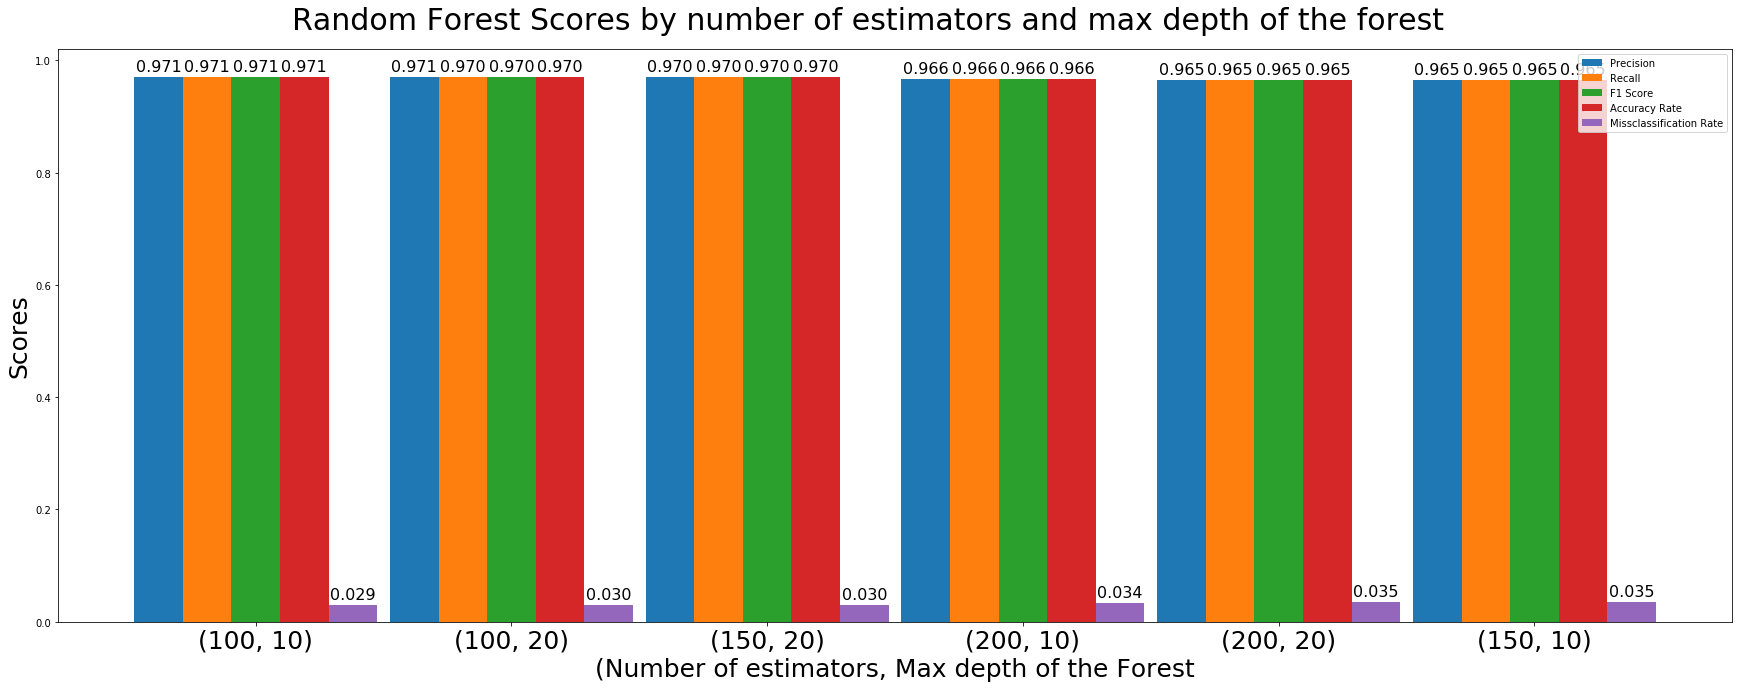

In [79]:
#draw_results( results['fakeFollowers'] )

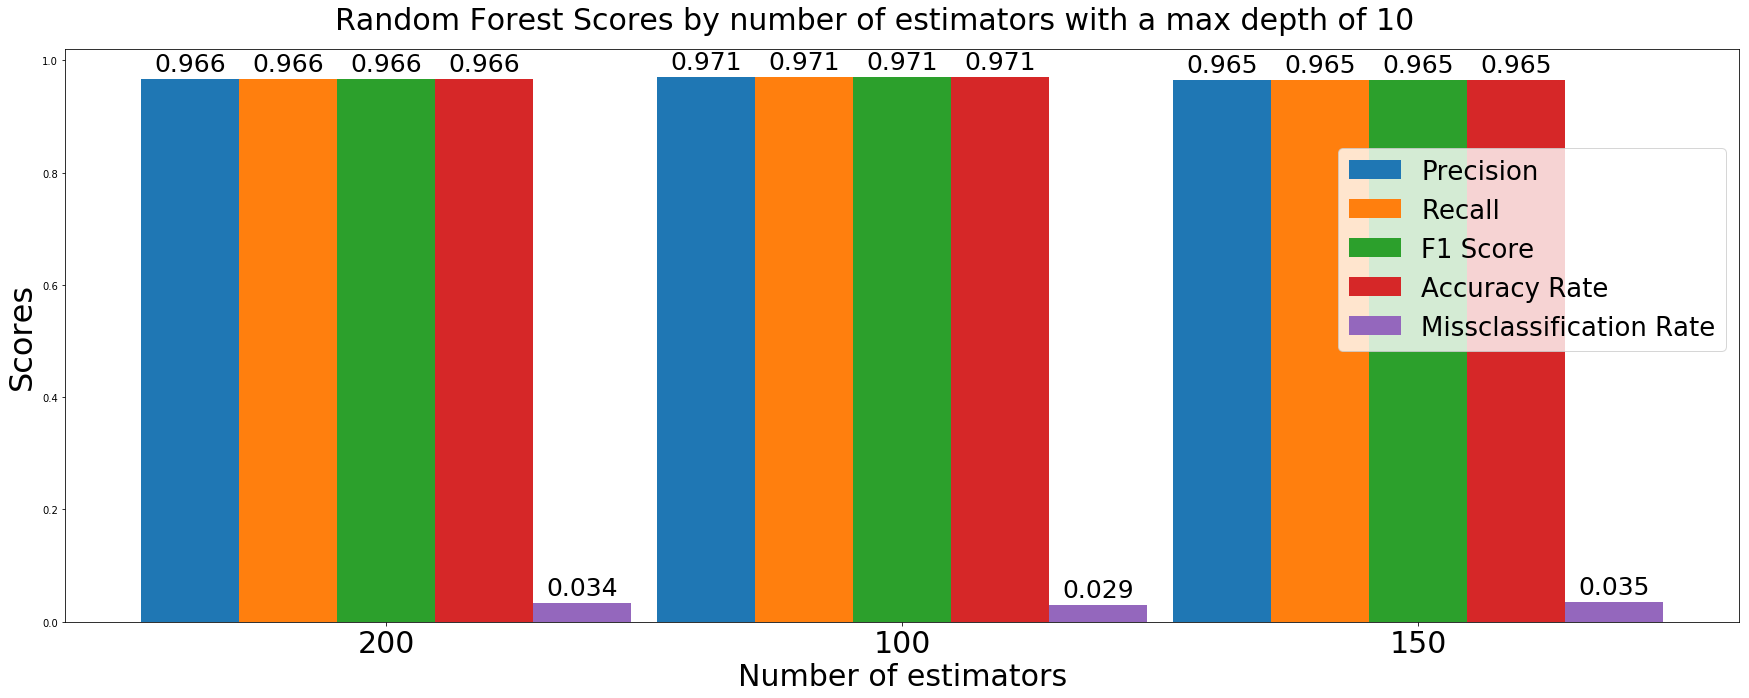

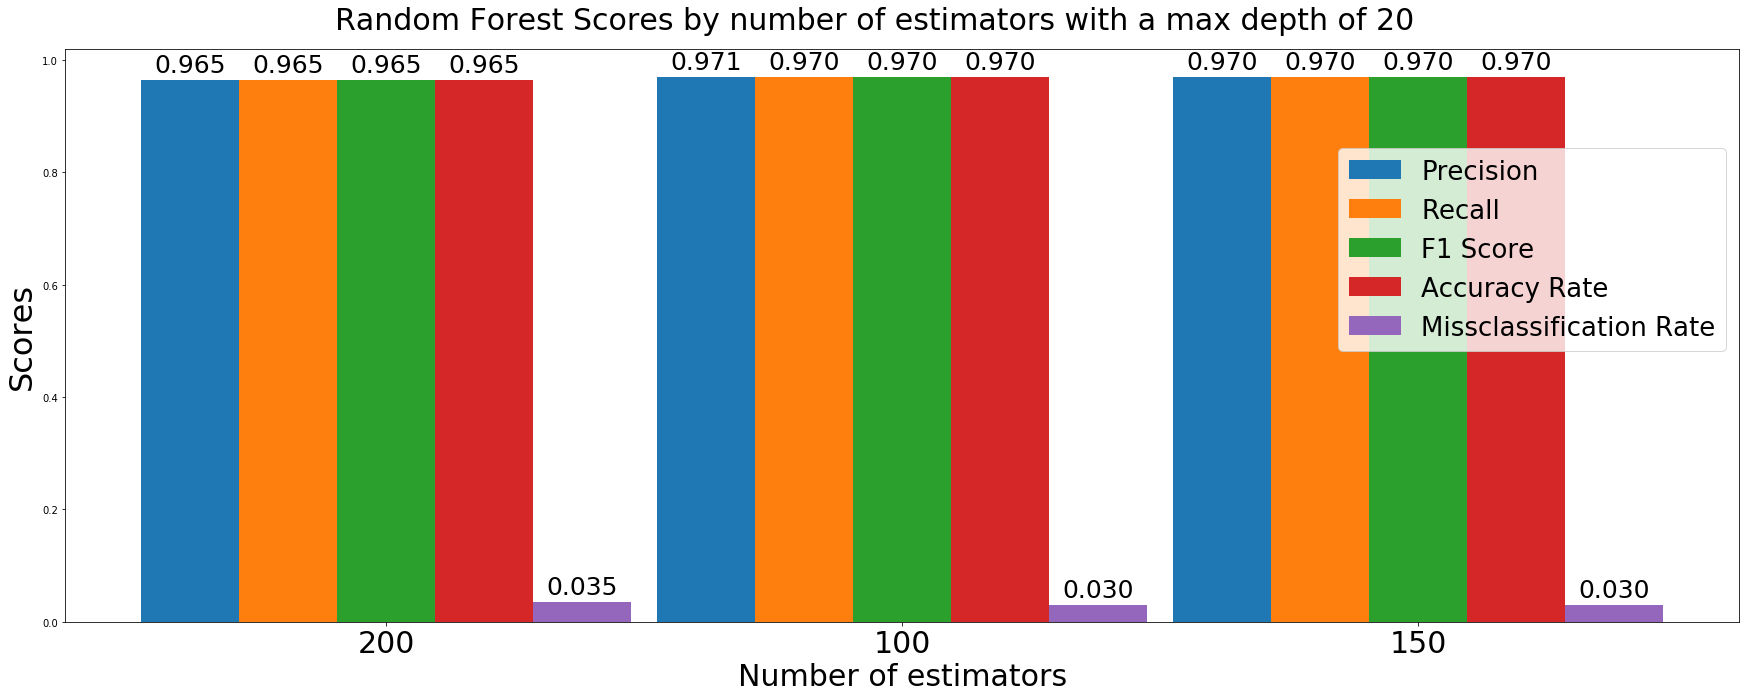

In [142]:
draw_results( results2['fakeFollowers'][10], 10 )
draw_results( results2['fakeFollowers'][20], 20 )

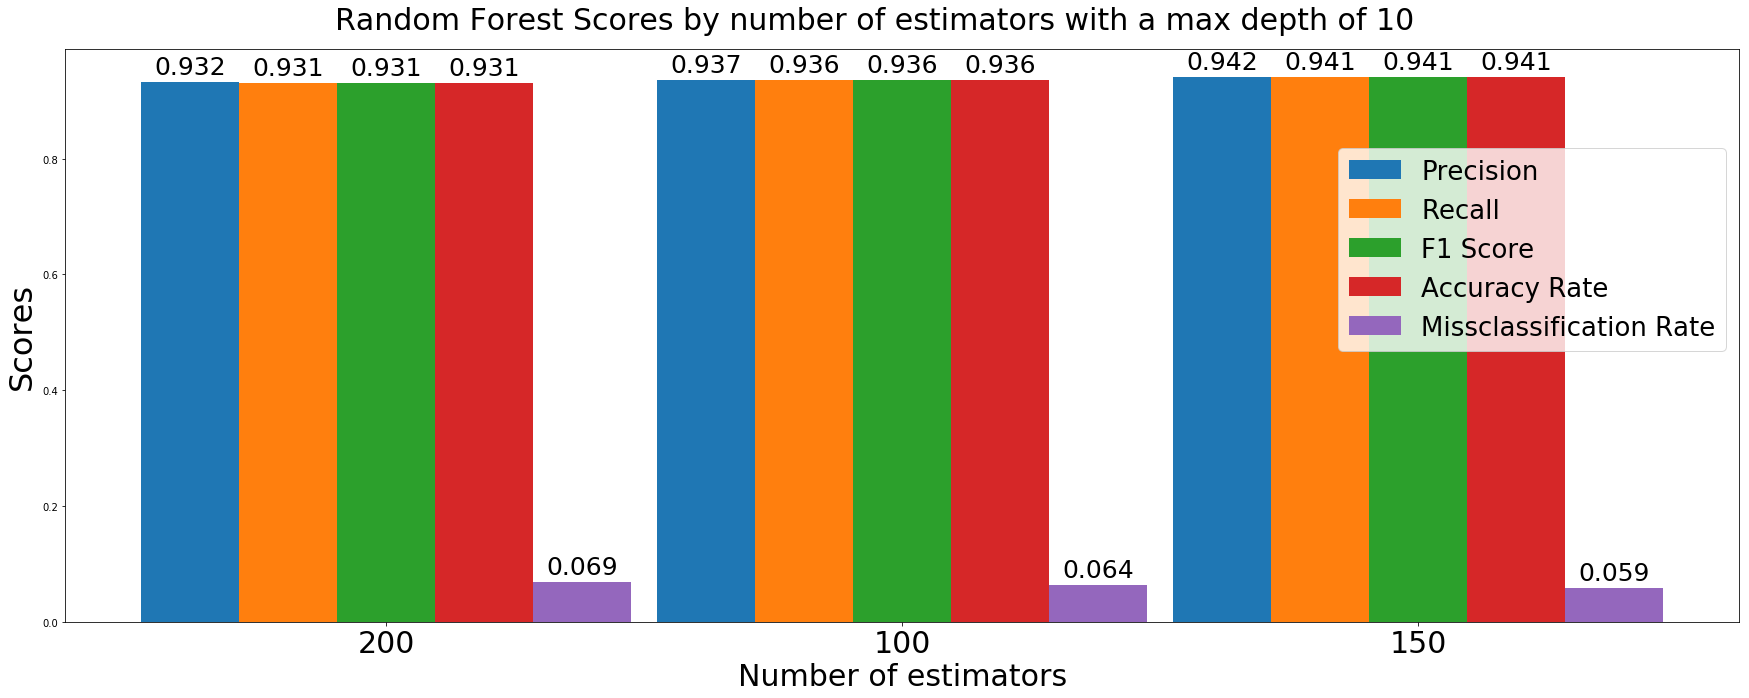

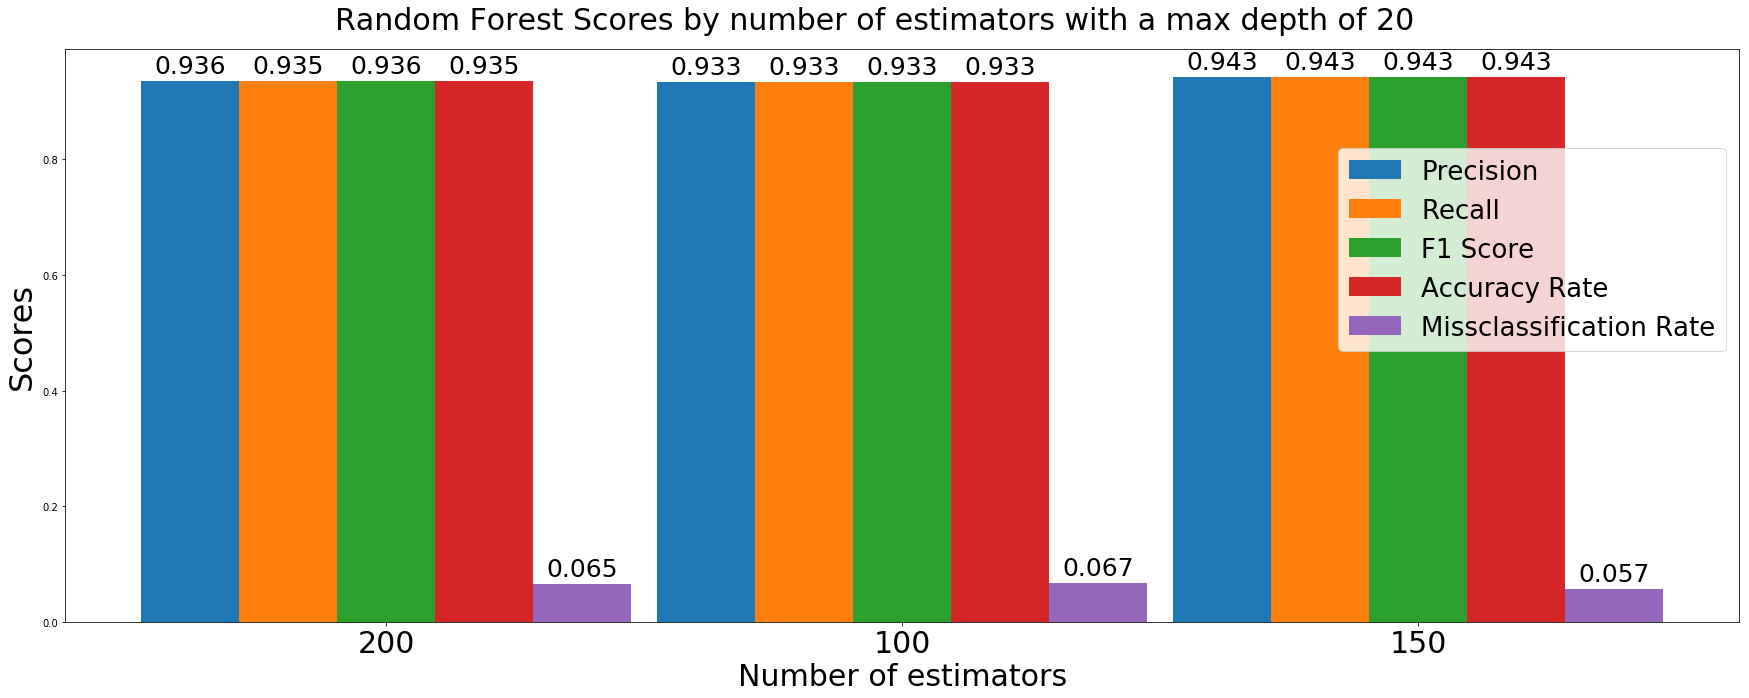

In [143]:
draw_results( results2['spamBots'][10], 10 )
draw_results( results2['spamBots'][20], 20 )

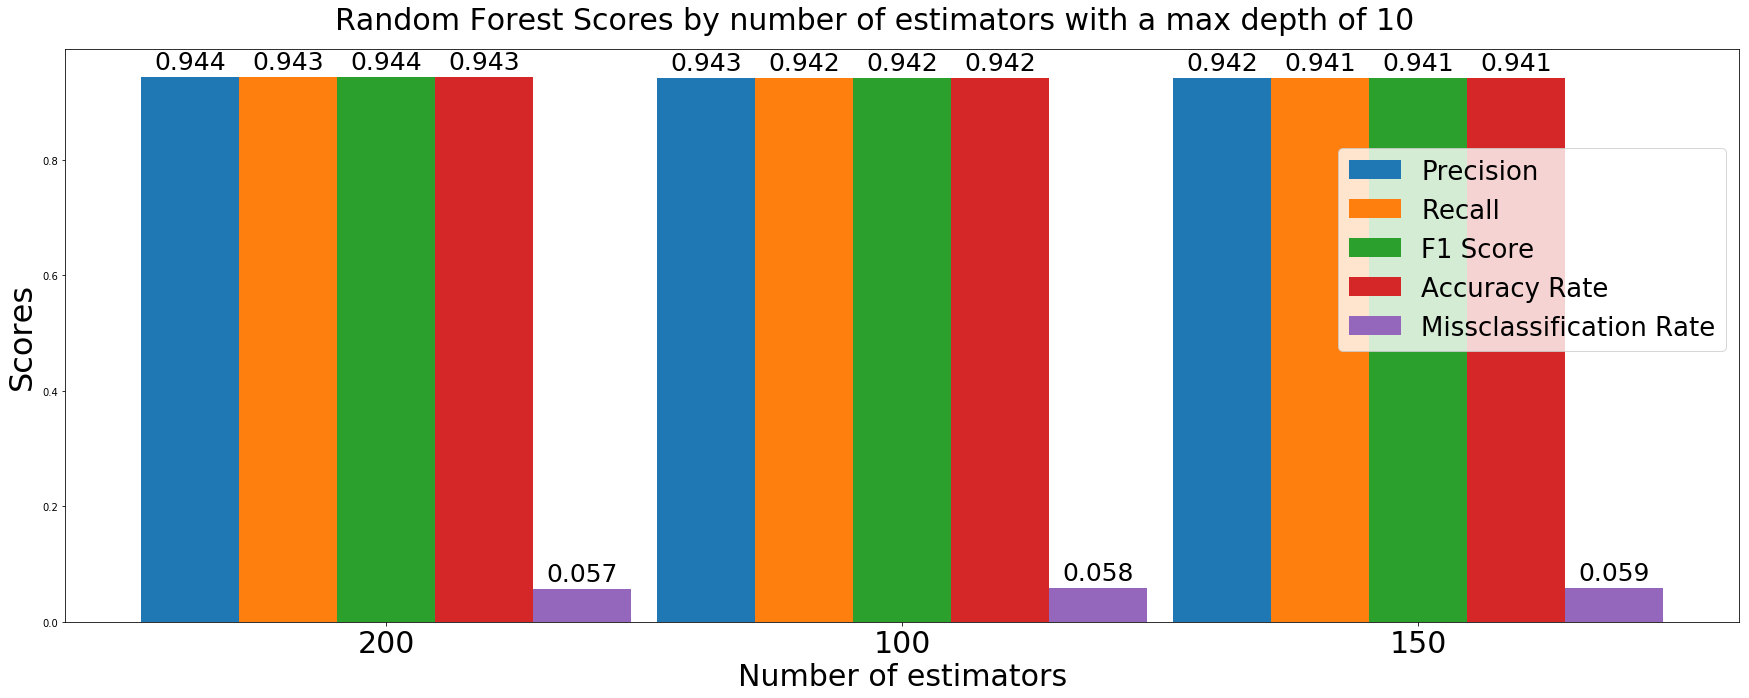

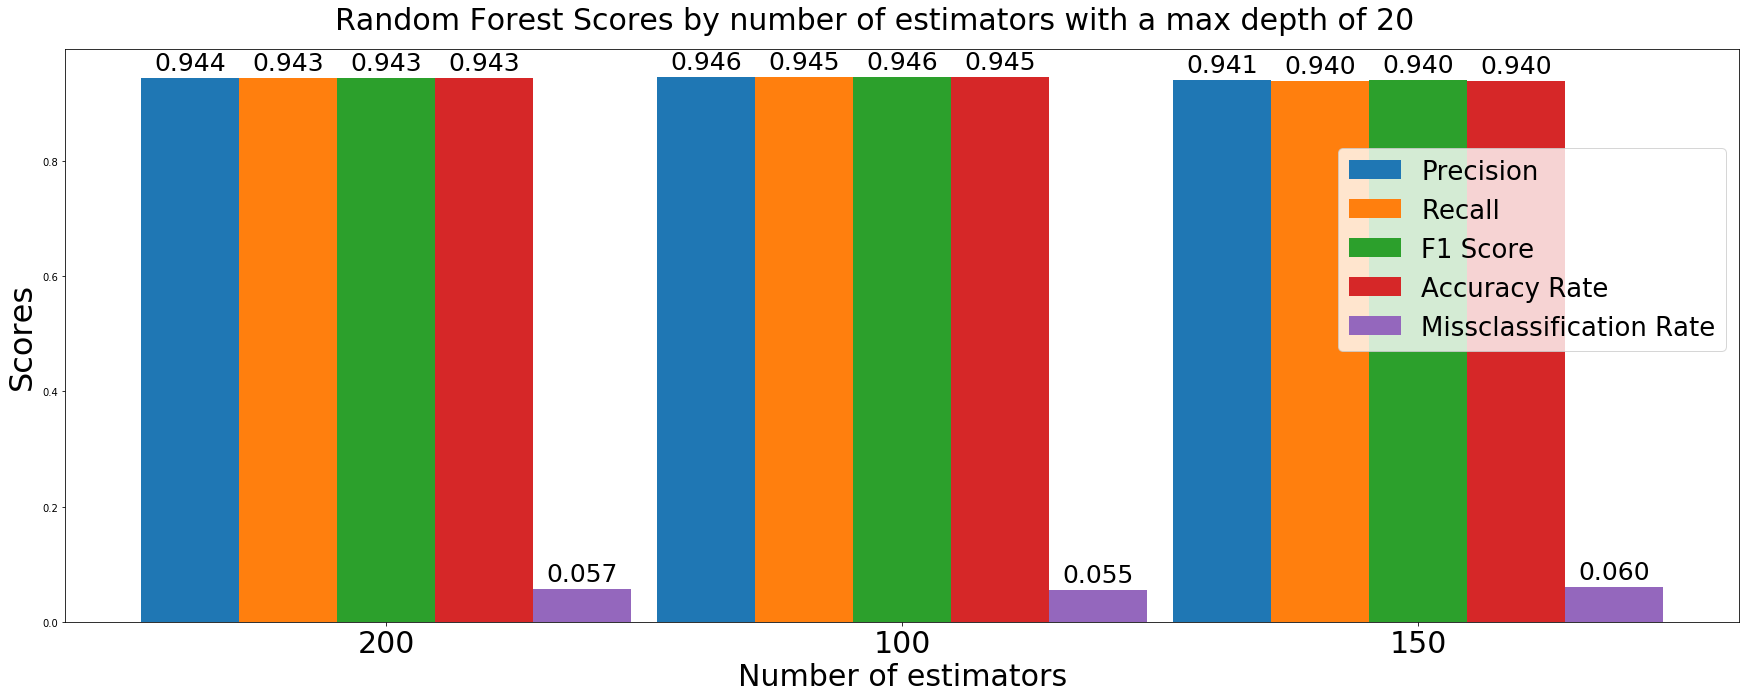

In [144]:
draw_results( results2['mix'][10], 10 )
draw_results( results2['mix'][20], 20 )

# LR analysis

In [159]:
def train_model_LR( X, y, name, results ):
    num_cv_iterations = 3
    num_instances = len(y)
    cv_object = ShuffleSplit( n_splits=num_cv_iterations, test_size = 0.2 )

    # first we create a reusable logisitic regression and random forest objects
    lr_clf = LogisticRegression( penalty='l2', C=1.0, class_weight=None ) # get object

    iter_num=0
    glob_acc = 0
    glob_precision = 0
    glob_recall = 0
    glob_f1 = 0
    glob_miss = 0
    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cv_object.split( X, y ):
        X_train = X[train_indices]
        y_train = y[train_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]

        # train the reusable logisitc regression model on the training data
        #lr_clf.fit( X_train, y_train ) # train object
        #y_pred = lr_clf.predict( X_test ) # get test set precitions

        lr_clf.fit( X_train, y_train ) # train object
        y_pred = lr_clf.predict( X_test ) # get test set precitions
        acc = mt.accuracy_score( y_test, y_pred )
        cmat = mt.confusion_matrix( y_test, y_pred )
        miss= np.divide(np.sum( [ float(cmat[0,1]), float(cmat[1,0]) ] ), np.sum(cmat) )
        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        print "\n====Iteration",iter_num," ===="
        print "LOGISTIC REGRESSION"        
        print( mt.classification_report( y_test, y_pred ) )
        print "Accuracy Rate: ", acc
        print('Misclassification Rate: {}'.format( miss ))
        print('\nTP - True Negative {}'.format(cmat[0,0]))
        print('FP - False Positive {}'.format(cmat[0,1]))
        print('FN - False Negative {}'.format(cmat[1,0]))
        print('TP - True Positive {}'.format(cmat[1,1]))
        
        precision,recall,fscore,support = mt.precision_recall_fscore_support(y_test, y_pred, average='weighted')       
        
        iter_num+=1
        glob_acc += acc
        glob_precision += precision
        glob_recall += recall
        glob_f1 += fscore
        glob_miss += miss
    glob_acc = float(glob_acc)/num_cv_iterations
    glob_precision = float(glob_precision)/num_cv_iterations
    glob_recall = float(glob_recall)/num_cv_iterations
    glob_f1 = float(glob_f1)/num_cv_iterations
    glob_miss = float(glob_miss)/num_cv_iterations
    results[name] = [ glob_precision, glob_recall, glob_f1, glob_acc, glob_miss]

In [160]:
names = [ 'fakeFollowers', 'spamBots', 'mix' ]
results_lr={}
for i in range( len( names ) ):
    print( "Creating a model to detect:" + names[i] )
    train_model_LR( XX[i], yy[i], names[i], results_lr )

Creating a model to detect:fakeFollowers

====Iteration 0  ====
LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       676
           1       0.97      0.97      0.97       689

   micro avg       0.97      0.97      0.97      1365
   macro avg       0.97      0.97      0.97      1365
weighted avg       0.97      0.97      0.97      1365

Accuracy Rate:  0.9714285714285714
Misclassification Rate: 0.0285714285714

TP - True Negative 655
FP - False Positive 21
FN - False Negative 18
TP - True Positive 671

====Iteration 1  ====
LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       684
           1       0.96      0.96      0.96       681

   micro avg       0.96      0.96      0.96      1365
   macro avg       0.96      0.96      0.96      1365
weighted avg       0.96      0.96      0.96      1365

Accuracy Rate:  0.958974358974359
Misclassification

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.96      0.99      0.97       694
           1       0.99      0.96      0.97       671

   micro avg       0.97      0.97      0.97      1365
   macro avg       0.97      0.97      0.97      1365
weighted avg       0.97      0.97      0.97      1365

Accuracy Rate:  0.9736263736263736
Misclassification Rate: 0.0263736263736

TP - True Negative 687
FP - False Positive 7
FN - False Negative 29
TP - True Positive 642
Creating a model to detect:spamBots

====Iteration 0  ====
LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       697
           1       0.93      0.94      0.94       981

   micro avg       0.92      0.92      0.92      1678
   macro avg       0.92      0.92      0.92      1678
weighted avg       0.92      0.92      0.92      1678

Accuracy Rate:  0.9249106078665077
Misclassification Rate: 0.0750893921335

TP - True Negative 633
F

In [172]:
results_lr

{'fakeFollowers': [0.9681734594933274,
  0.968009768009768,
  0.9680048611299275,
  0.968009768009768,
  0.031990231990231995],
 'mix': [0.9377582310601692,
  0.9376774559909142,
  0.9376354960891385,
  0.9376774559909142,
  0.06232254400908575],
 'spamBots': [0.9320407447126667,
  0.9320619785458879,
  0.9319589828991415,
  0.9320619785458879,
  0.06793802145411204]}

In [170]:
def draw_results2( results ): 
    labels = results.keys()
    precision = [item[0] for item in results.values() ]
    recall = [item[1] for item in results.values() ]
    f1 = [item[2] for item in results.values() ]
    acc = [item[3] for item in results.values() ]
    miss = [item[4] for item in results.values() ]

    x = np.arange( len(labels) )  # the label locations
    width = 0.19  # the width of the bars

    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(30, 10))

    rects1 = ax.bar(x - 2*width, precision, width, label='Precision')
    rects2 = ax.bar(x - width, recall, width, label='Recall')
    rects3 = ax.bar(x , f1, width, label='F1 Score')
    rects4 = ax.bar(x + width, acc, width, label='Accuracy Rate')
    rects5 = ax.bar(x + 2*width, miss, width, label='Missclassification Rate')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores', fontsize=32)
    #ax.set_xlabel('(Number of estimators, Max depth of the Forest', fontsize=25)
    #ax.set_xlabel('Dataset used', fontsize=30)
    _str = 'Logistic Regression Scores' 
    fig.suptitle( _str, fontsize=36)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=30)

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{0:.3f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points", ha='center', va='bottom',
                        fontsize=25)


    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    autolabel(rects5)

    #fig.tight_layout()
    ax.legend( loc=1, prop={'size': 26}, bbox_to_anchor = [1.0, 0.85] )
    fig.subplots_adjust(top=0.92)
    plt.show()

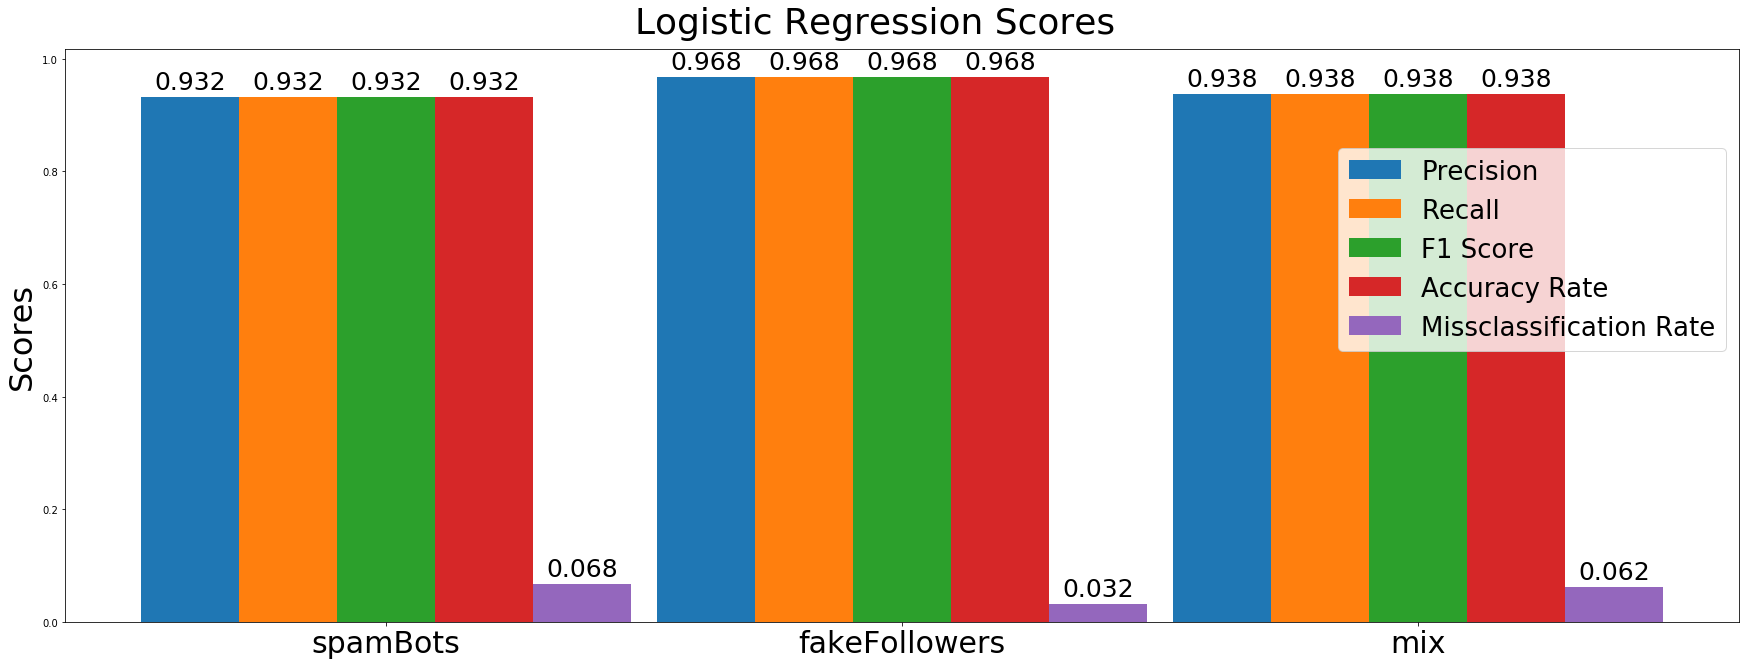

In [171]:
draw_results2( results_lr )

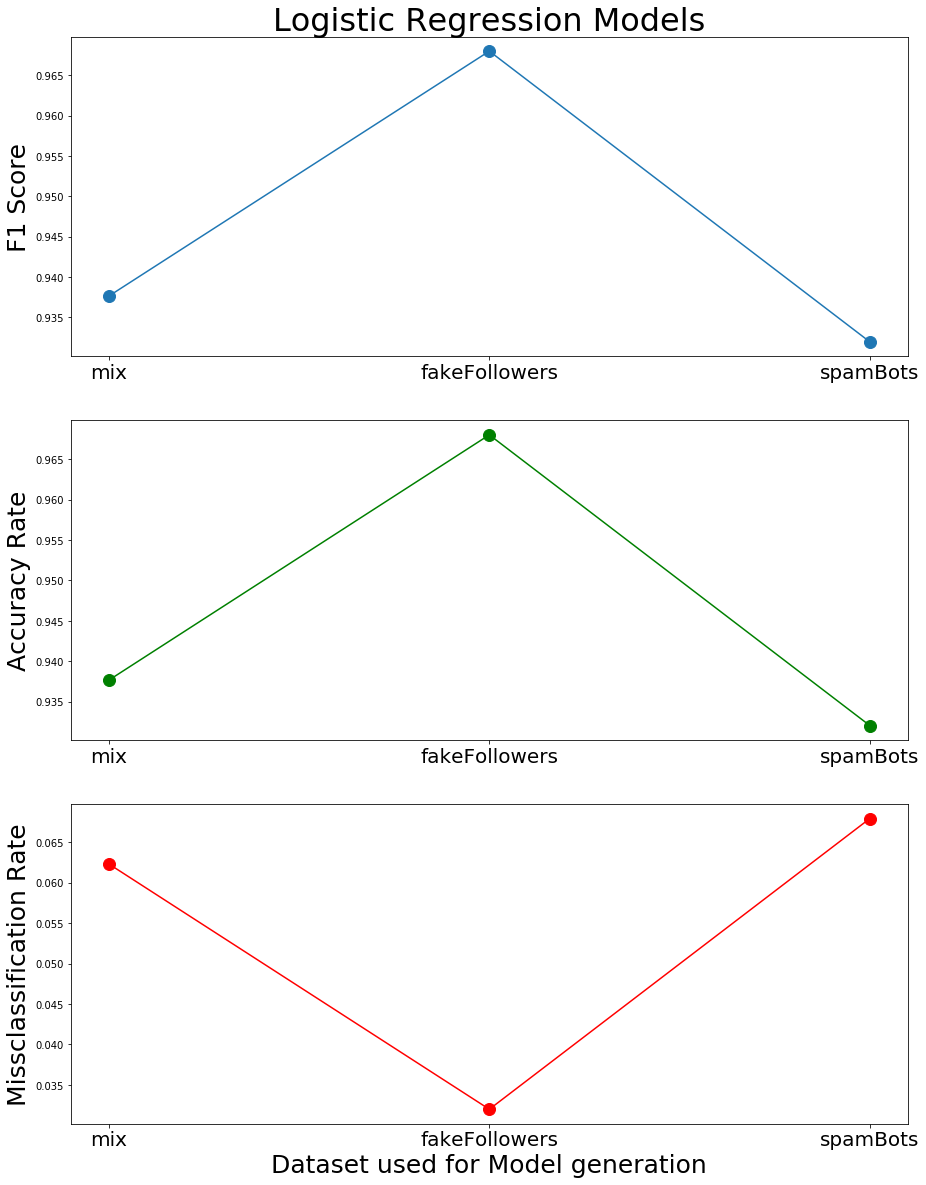

In [62]:
labels = results_lr.keys()

f1 = [item[2] for item in results_lr.values() ]
acc = [item[3] for item in results_lr.values() ]
miss = [item[4] for item in results_lr.values() ]

x = np.arange( len(labels) )  # the label locations
#width = 0.19  # the width of the bars

y1=[ f1[0],f1[1],f1[2] ]
y2=[ acc[0],acc[1],acc[2] ]
y3=[ miss[0],miss[1],miss[2] ]

fig, ax = plt.subplots(figsize=(15, 20))
#plt.figure( figsize=(20, 25) )

plt.subplot(3, 1, 1)
plt.plot(x, y1, 'o-', markersize=12, label='F1 Score')
plt.title('Logistic Regression Models', fontsize=32 )
plt.ylabel('F1 Score', fontsize=25)
plt.xticks(range(3), labels, fontsize=20)

plt.subplot(3, 1, 2)
plt.plot(x, y2, 'o-', markersize=12, label='Accuracy Rate', color='green')
plt.ylabel('Accuracy Rate', fontsize=25)
plt.xticks(range(3), labels, fontsize=20)

plt.subplot(3, 1, 3)
plt.plot(x, y3, 'o-', markersize=12, label='Missclassification Rate', color='red')
plt.xlabel('Dataset used for Model generation', fontsize=25)
plt.ylabel('Missclassification Rate', fontsize=25)
plt.xticks(range(3), labels, fontsize=20)

#ax.set_xticks(x)
#fig.legend( loc=1, prop={'size': 26})#, bbox_to_anchor = [1.0, 0.85] )
#fig.subplots_adjust(top=0.92 )
plt.show()

# KNN analysis

In [14]:
def knn_nneighbors_analysis( X, y ):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
    error_rate = []

    for i in range(1,40):
        knn = KNeighborsClassifier( n_neighbors = i )
        knn.fit( X_train, y_train )
        y_pred = knn.predict( X_test )
        error_rate.append( np.mean( y_pred != y_test) )
    
    plt.figure(figsize=(10,4))
    plt.plot(range(1,40), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K-Values')
    plt.xlabel('K-Values')
    plt.ylabel('Error Rate')

In [15]:
def knn_analysis( X, y, neighbors ):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    knn = KNeighborsClassifier( n_neighbors=neighbors )
    knn.fit( X_train, y_train )
    y_pred = knn.predict( X_test )
    acc = mt.accuracy_score( y_test, y_pred )
    cmat = mt.confusion_matrix( y_test, y_pred )
    print( mt.classification_report( y_test, y_pred ) )
    print "Accuracy Rate: ", acc
    print('Misclassification Rate: {}'.format( np.divide(np.sum( [ float(cmat[0,1]), float(cmat[1,0]) ] ), np.sum(cmat) ) ) )
    print('\nTP - True Negative {}'.format(cmat[0,0]))
    print('FP - False Positive {}'.format(cmat[0,1]))
    print('FN - False Negative {}'.format(cmat[1,0]))
    print('TP - True Positive {}'.format(cmat[1,1]))

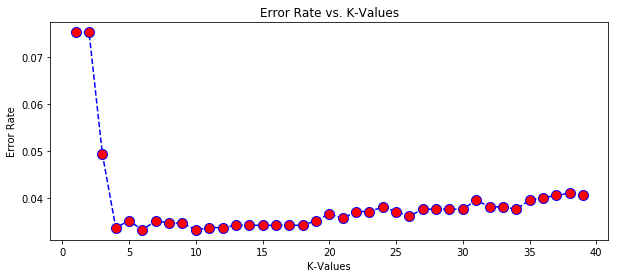

In [23]:
knn_nneighbors_analysis( XX[0], yy[0] )

In [26]:
knn_analysis( XX[0], yy[0], 4 )

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1035
           1       0.98      0.96      0.97      1013

   micro avg       0.97      0.97      0.97      2048
   macro avg       0.97      0.97      0.97      2048
weighted avg       0.97      0.97      0.97      2048

Accuracy Rate:  0.96630859375
Misclassification Rate: 0.03369140625

TP - True Negative 1011
FP - False Positive 24
FN - False Negative 45
TP - True Positive 968


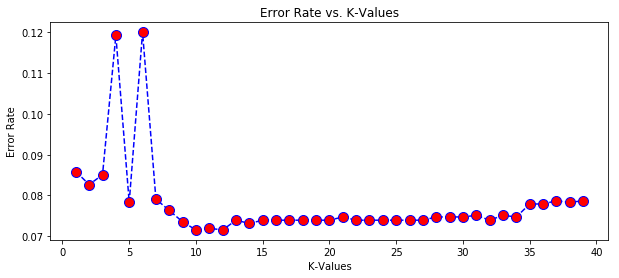

In [24]:
knn_nneighbors_analysis( XX[1], yy[1] )

In [28]:
knn_analysis( XX[1], yy[1], 10 )

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1041
           1       0.95      0.92      0.94      1475

   micro avg       0.93      0.93      0.93      2516
   macro avg       0.92      0.93      0.93      2516
weighted avg       0.93      0.93      0.93      2516

Accuracy Rate:  0.9284578696343402
Misclassification Rate: 0.0715421303657

TP - True Negative 972
FP - False Positive 69
FN - False Negative 111
TP - True Positive 1364


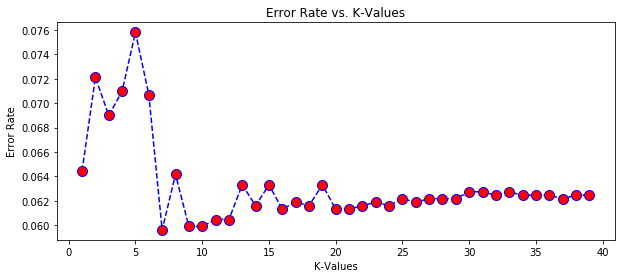

In [29]:
knn_nneighbors_analysis( XX[2], yy[2] )

In [30]:
knn_analysis( XX[2], yy[2], 7 )

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1046
           1       0.97      0.95      0.96      2476

   micro avg       0.94      0.94      0.94      3522
   macro avg       0.92      0.93      0.93      3522
weighted avg       0.94      0.94      0.94      3522

Accuracy Rate:  0.9403747870528109
Misclassification Rate: 0.0596252129472

TP - True Negative 964
FP - False Positive 82
FN - False Negative 128
TP - True Positive 2348


In [173]:
def draw_results3( results ): 
    labels = results.keys()
    precision = [item[0] for item in results.values() ]
    recall = [item[1] for item in results.values() ]
    f1 = [item[2] for item in results.values() ]
    acc = [item[3] for item in results.values() ]
    miss = [item[4] for item in results.values() ]

    x = np.arange( len(labels) )  # the label locations
    width = 0.19  # the width of the bars

    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(30, 10))

    rects1 = ax.bar(x - 2*width, precision, width, label='Precision')
    rects2 = ax.bar(x - width, recall, width, label='Recall')
    rects3 = ax.bar(x , f1, width, label='F1 Score')
    rects4 = ax.bar(x + width, acc, width, label='Accuracy Rate')
    rects5 = ax.bar(x + 2*width, miss, width, label='Missclassification Rate')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores', fontsize=32)
    #ax.set_xlabel('(Number of estimators, Max depth of the Forest', fontsize=25)
    #ax.set_xlabel('Dataset used', fontsize=30)
    _str = 'KNN Scores' 
    fig.suptitle( _str, fontsize=36)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=30)

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{0:.3f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points", ha='center', va='bottom',
                        fontsize=25)


    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    autolabel(rects5)

    #fig.tight_layout()
    ax.legend( loc=1, prop={'size': 26}, bbox_to_anchor = [1.0, 0.85] )
    fig.subplots_adjust(top=0.92)
    plt.show()

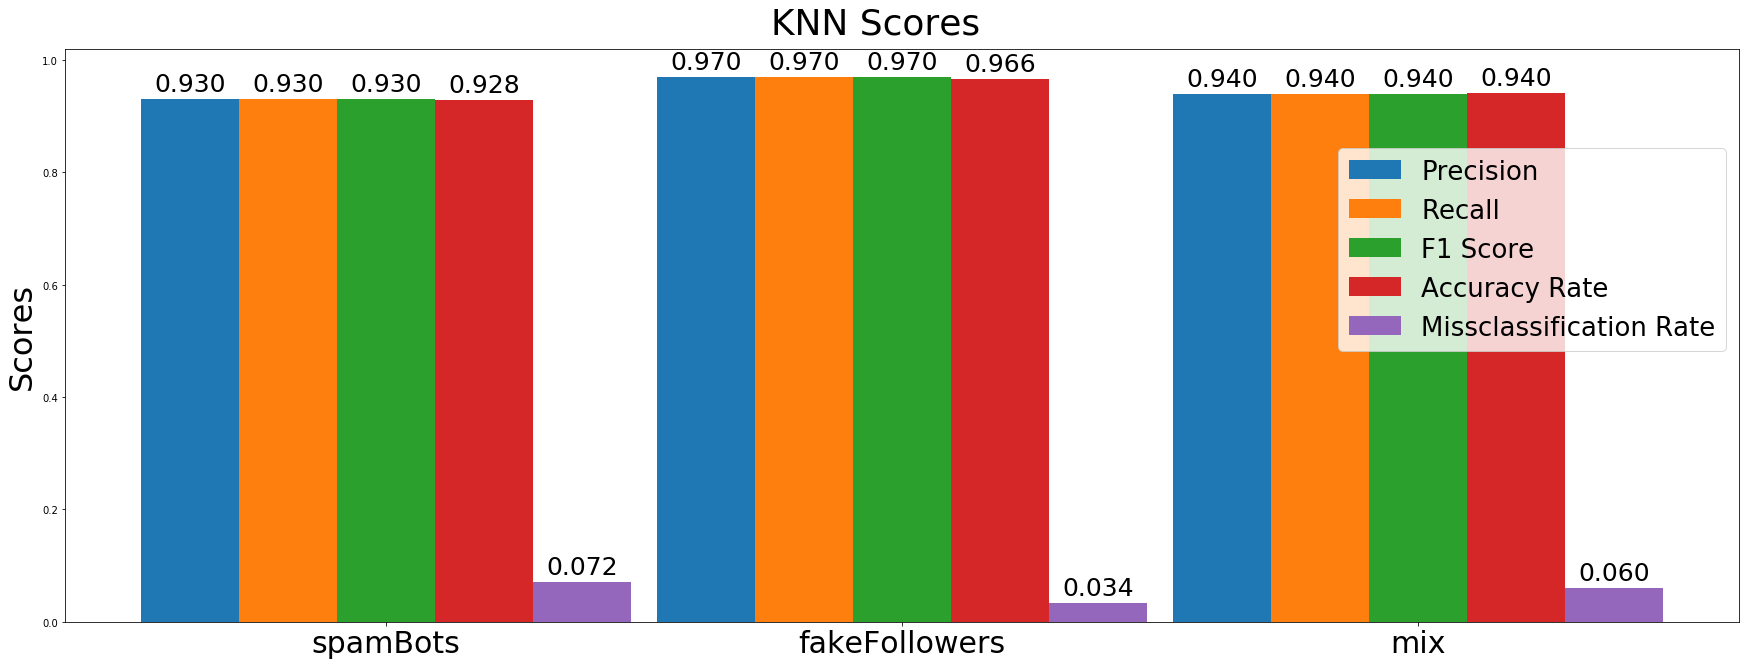

In [174]:
results_knn = { 'fakeFollowers':[0.970, 0.970, 0.970, 0.96630859375, 0.03369140625], 
               'spamBots':[0.930, 0.930, 0.930, 0.9284578696343402, 0.0715421303657],
               'mix':[0.940, 0.940, 0.940, 0.9403747870528109, 0.0596252129472] }
draw_results3( results_knn )

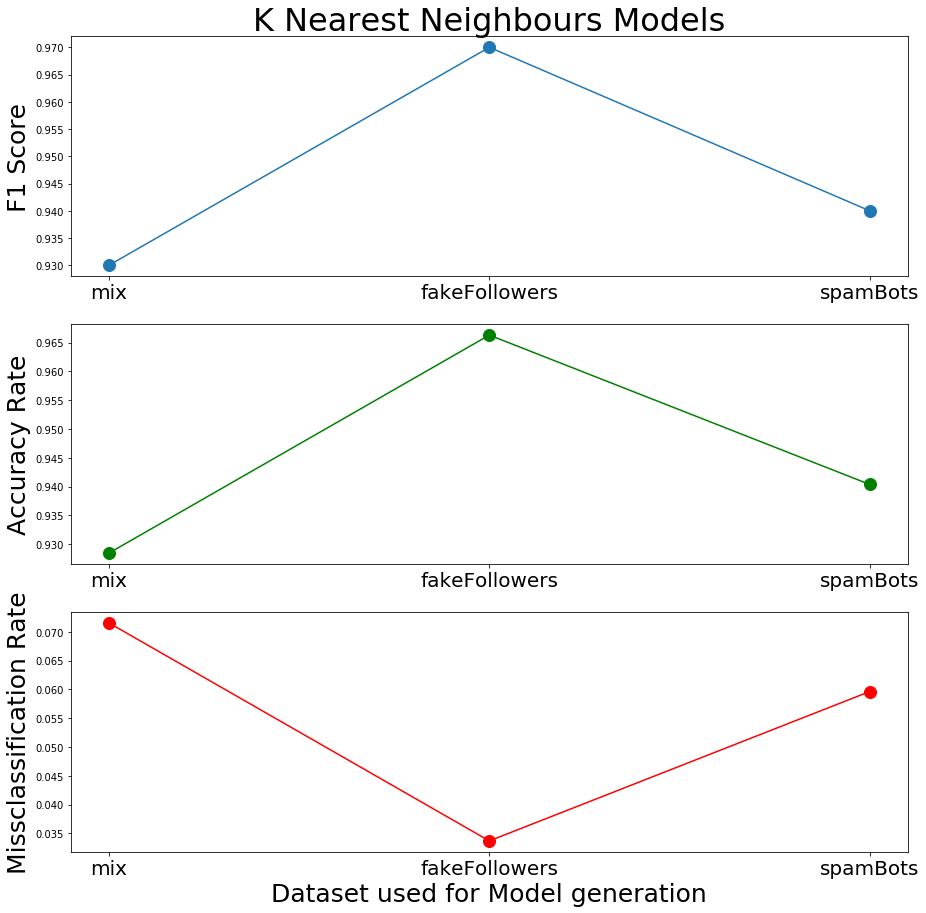

In [65]:
results_knn={ 'fakeFollowers':[0.970, 0.970, 0.970, 0.96630859375, 0.03369140625], 
               'spamBots':[0.930, 0.930, 0.930, 0.9284578696343402, 0.0715421303657],
               'mix':[0.940, 0.940, 0.940, 0.9403747870528109, 0.0596252129472] }

labels = results_knn.keys()

f1 = [item[2] for item in results_knn.values() ]
acc = [item[3] for item in results_knn.values() ]
miss = [item[4] for item in results_knn.values() ]

x = np.arange( len(labels) )  # the label locations
#width = 0.19  # the width of the bars

y1=[ f1[0],f1[1],f1[2] ]
y2=[ acc[0],acc[1],acc[2] ]
y3=[ miss[0],miss[1],miss[2] ]

fig, ax = plt.subplots(figsize=(15, 15))
#plt.figure( figsize=(20, 25) )

plt.subplot(3, 1, 1)
plt.plot(x, y1, 'o-', markersize=12, label='F1 Score')
plt.title('K Nearest Neighbours Models', fontsize=32 )
plt.ylabel('F1 Score', fontsize=25)
plt.xticks(range(3), labels, fontsize=20)

plt.subplot(3, 1, 2)
plt.plot(x, y2, 'o-', markersize=12, label='Accuracy Rate', color='green')
plt.ylabel('Accuracy Rate', fontsize=25)
plt.xticks(range(3), labels, fontsize=20)

plt.subplot(3, 1, 3)
plt.plot(x, y3, 'o-', markersize=12, label='Missclassification Rate', color='red')
plt.xlabel('Dataset used for Model generation', fontsize=25)
plt.ylabel('Missclassification Rate', fontsize=25)
plt.xticks(range(3), labels, fontsize=20)

#ax.set_xticks(x)
#fig.legend( loc=1, prop={'size': 26})#, bbox_to_anchor = [1.0, 0.85] )
#fig.subplots_adjust(top=0.92 )
plt.show()

# Overall Comparison

In [4]:
def draw_results3( results, dataset ): 
    labels = results.keys()
    precision = [item[0] for item in results.values() ]
    recall = [item[1] for item in results.values() ]
    f1 = [item[2] for item in results.values() ]
    acc = [item[3] for item in results.values() ]
    miss = [item[4] for item in results.values() ]

    x = np.arange( len(labels) )  # the label locations
    width = 0.19  # the width of the bars

    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(30, 10))

    rects1 = ax.bar(x - 2*width, precision, width, label='Precision')
    rects2 = ax.bar(x - width, recall, width, label='Recall')
    rects3 = ax.bar(x , f1, width, label='F1 Score')
    rects4 = ax.bar(x + width, acc, width, label='Accuracy Rate')
    rects5 = ax.bar(x + 2*width, miss, width, label='Missclassification Rate')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores', fontsize=32)
    #ax.set_xlabel('(Number of estimators, Max depth of the Forest', fontsize=25)
    #ax.set_xlabel('Dataset used', fontsize=30)
    _str = 'Overall comparison of the Models using the '+dataset+' dataset' 
    fig.suptitle( _str, fontsize=36)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=30)

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{0:.3f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points", ha='center', va='bottom',
                        fontsize=25)


    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    autolabel(rects5)

    #fig.tight_layout()
    ax.legend( loc=1, prop={'size': 26}, bbox_to_anchor = [1.0, 0.85] )
    fig.subplots_adjust(top=0.92)
    plt.show()

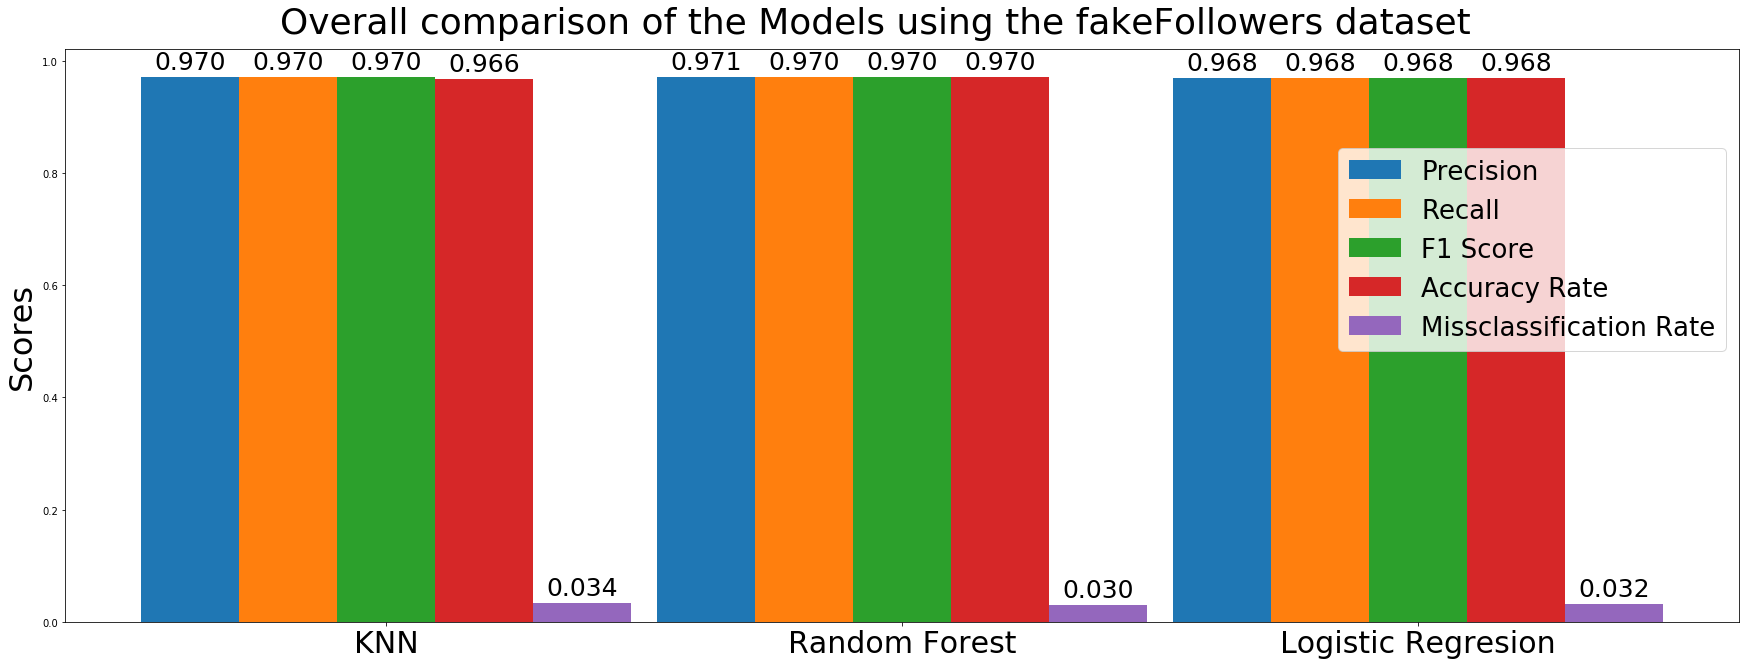

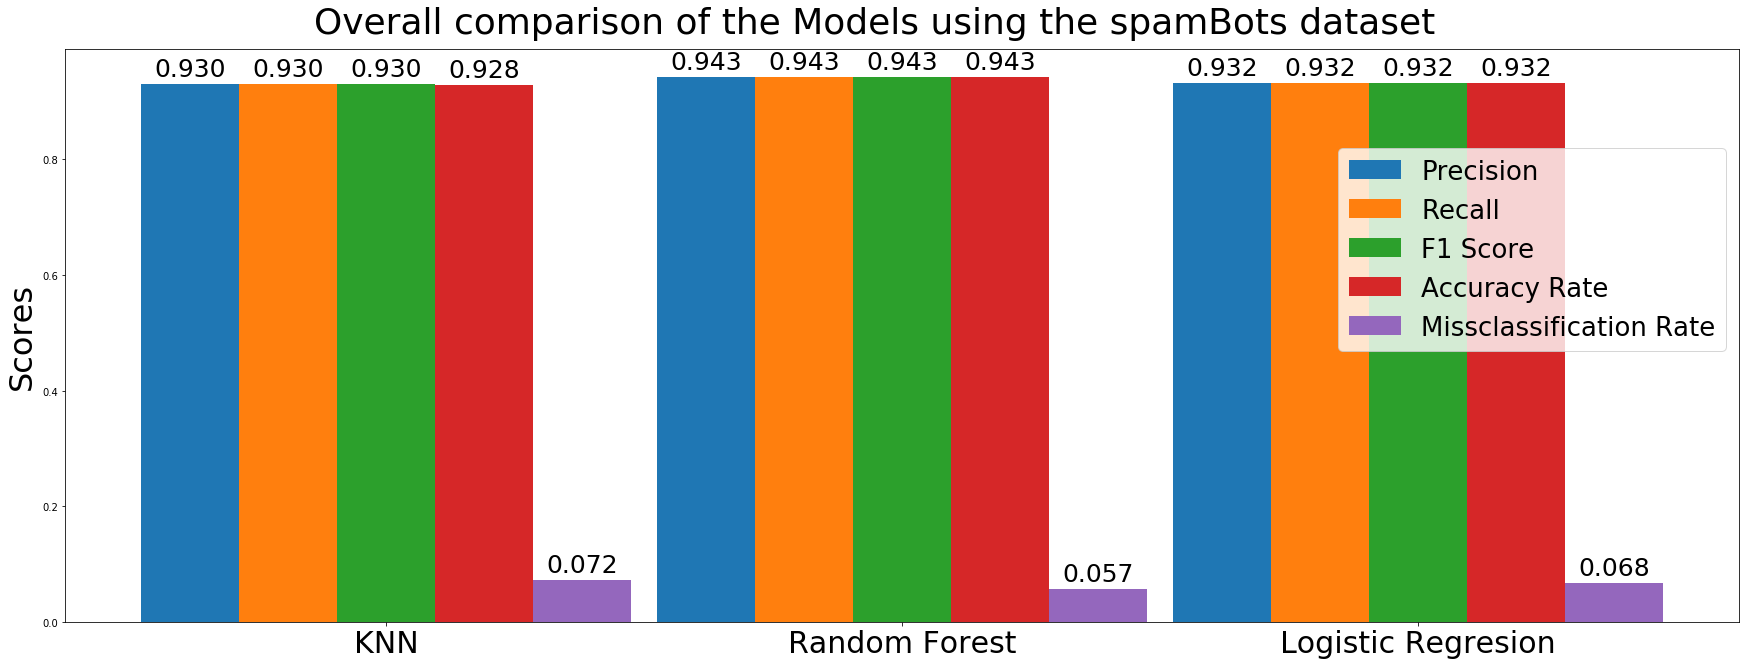

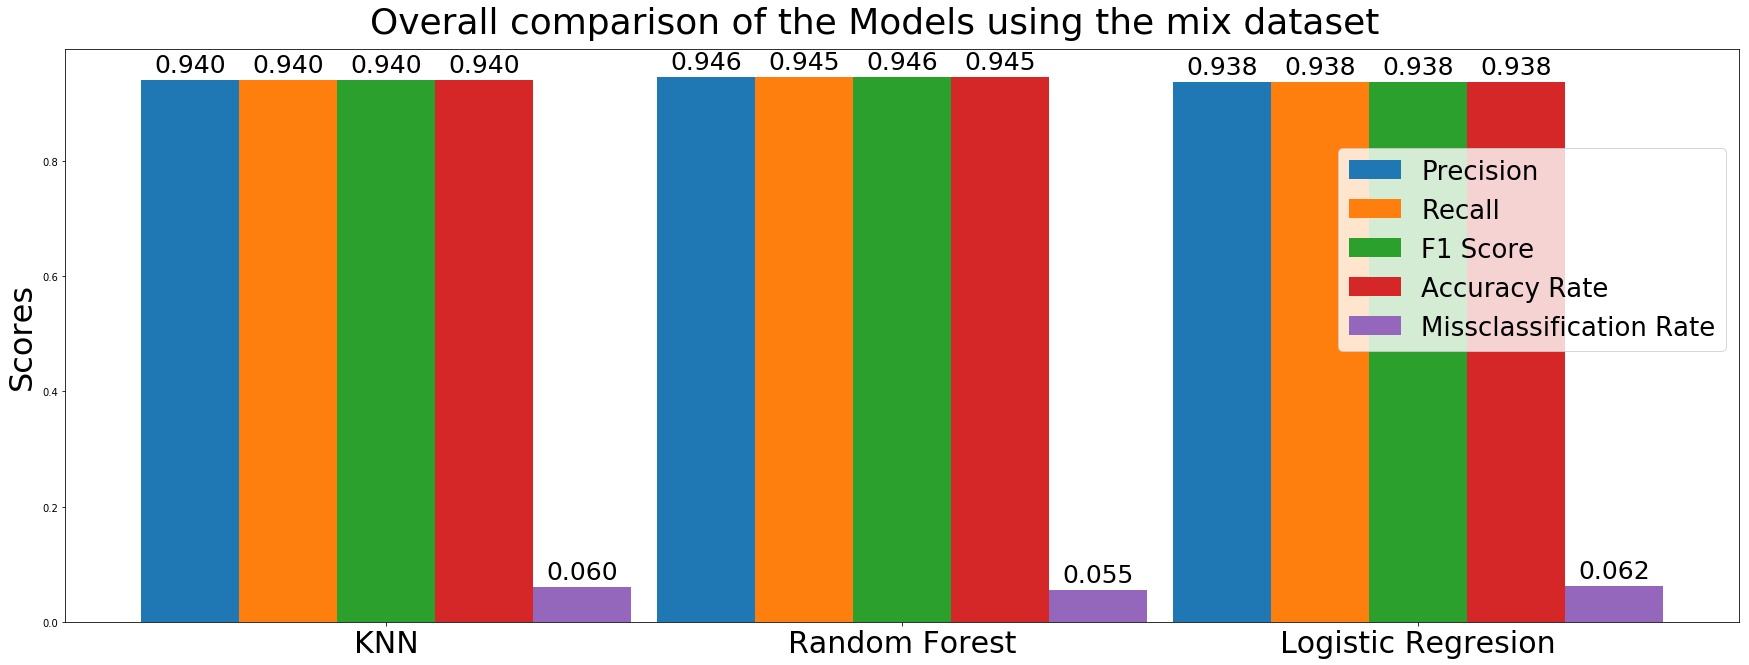

In [5]:
overall_results ={
'fakeFollowers' : { 
    'Random Forest': [0.9712638405779637, 0.9700561660561661, 0.970050206388083, 0.9700561660561661, 0.03034383394383394],
    'Logistic Regresion': [0.9681734594933274, 0.968009768009768, 0.9680048611299275, 0.968009768009768, 0.031990231990231995],
    'KNN':[0.970, 0.970, 0.970, 0.96630859375, 0.03369140625], 
},
'spamBots' : { 
    'Random Forest': [0.9425073630081926, 0.9432133492252682, 0.9432863975905493, 0.9427133492252682, 0.05678665077473183],
    'Logistic Regresion': [0.9320407447126667, 0.9320619785458879, 0.9319589828991415, 0.9320619785458879, 0.06793802145411204],
    'KNN':[0.930, 0.930, 0.930, 0.9284578696343402, 0.0715421303657]
},   
'mix' : { 
    'Random Forest': [0.9463200083512474, 0.9454855195911414, 0.9457617257252018, 0.9454855195911414, 0.05451448040885861],
    'Logistic Regresion': [0.9377582310601692,  0.9376774559909142,  0.9376354960891385,  0.9376774559909142,  0.06232254400908575 ],
    'KNN':[0.940, 0.940, 0.940, 0.9403747870528109, 0.0596252129472]
}}

draw_results3( overall_results['fakeFollowers'], 'fakeFollowers' )
draw_results3( overall_results['spamBots'], 'spamBots' )
draw_results3( overall_results['mix'], 'mix' )


In [6]:
def draw_results3_v2( results, dataset ): 
    labels = results.keys()

    f1 = [item[2] for item in results.values() ]
    acc = [item[3] for item in results.values() ]
    miss = [item[4] for item in results.values() ]

    x = np.arange( len(labels) )  # the label locations
    #width = 0.19  # the width of the bars

    y1=[ f1[0],f1[1],f1[2] ]
    y2=[ acc[0],acc[1],acc[2] ]
    y3=[ miss[0],miss[1],miss[2] ]
    
    _str = 'Overall comparison of the Models using the '+dataset+' dataset' 

    fig, ax = plt.subplots(figsize=(15, 15))
    #plt.figure( figsize=(20, 25) )

    plt.subplot(3, 1, 1)
    plt.plot(x, y1, 'o-', markersize=12, label='F1 Score')
    plt.title( _str, fontsize=32 )
    plt.ylabel('F1 Score', fontsize=25)
    plt.xticks(range(3), labels, fontsize=20)

    plt.subplot(3, 1, 2)
    plt.plot(x, y2, 'o-', markersize=12, label='Accuracy Rate', color='green')
    plt.ylabel('Accuracy Rate', fontsize=25)
    plt.xticks(range(3), labels, fontsize=20)

    plt.subplot(3, 1, 3)
    plt.plot(x, y3, 'o-', markersize=12, label='Missclassification Rate', color='red')
    plt.xlabel('Dataset used for Model generation', fontsize=25)
    plt.ylabel('Missclassification Rate', fontsize=25)
    plt.xticks(range(3), labels, fontsize=20)

    #ax.set_xticks(x)
    #fig.legend( loc=1, prop={'size': 26})#, bbox_to_anchor = [1.0, 0.85] )
    #fig.subplots_adjust(top=0.92 )
    plt.show()

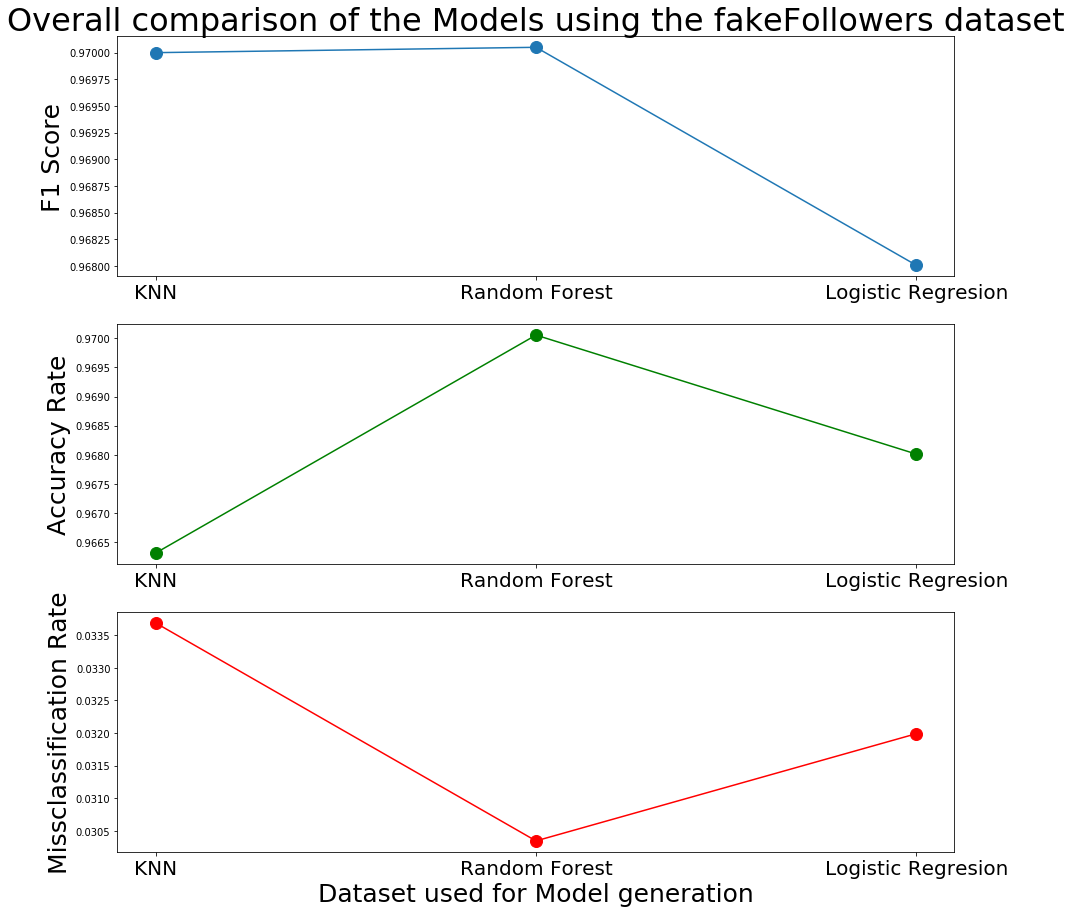

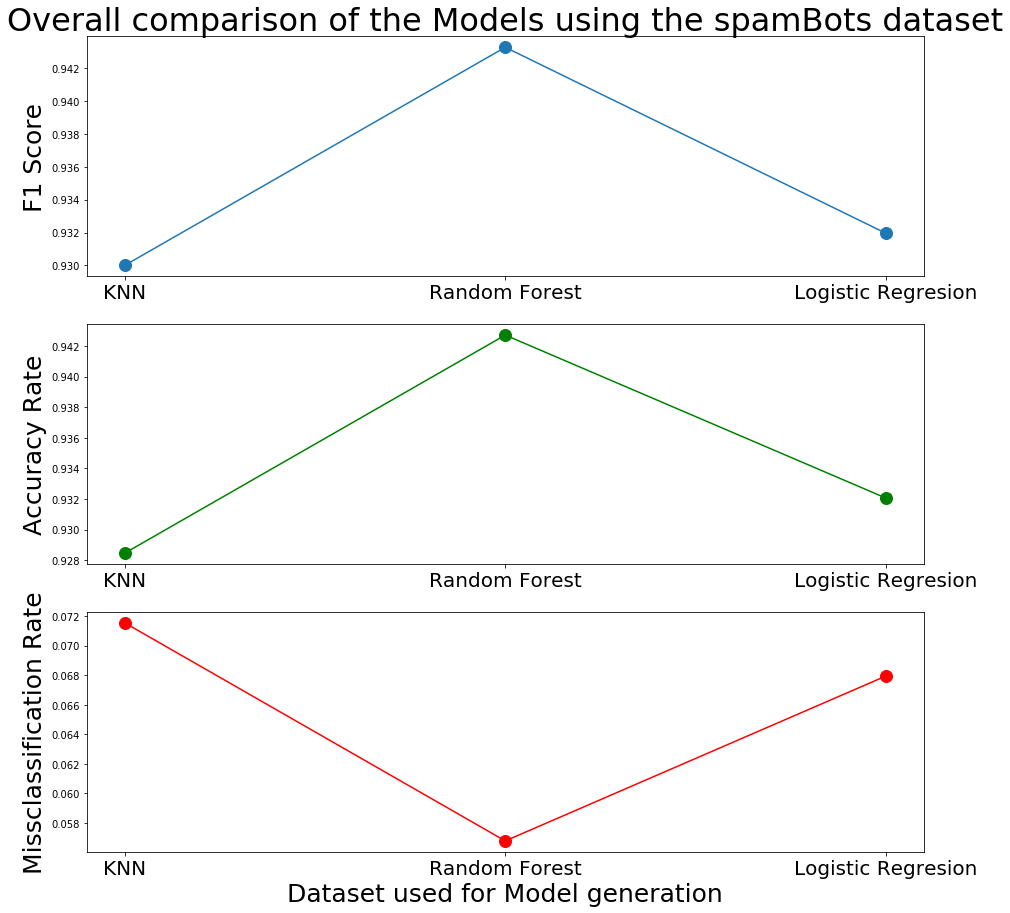

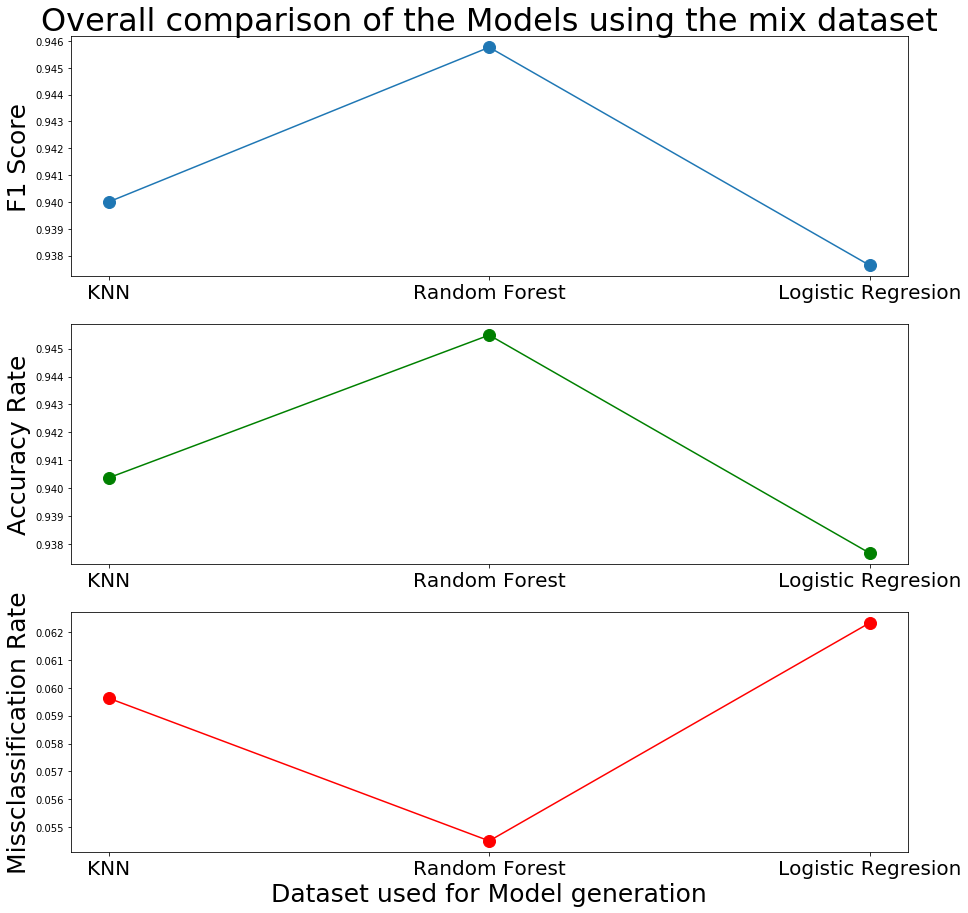

In [7]:
overall_results ={
'fakeFollowers' : { 
    'Random Forest': [0.9712638405779637, 0.9700561660561661, 0.970050206388083, 0.9700561660561661, 0.03034383394383394],
    'Logistic Regresion': [0.9681734594933274, 0.968009768009768, 0.9680048611299275, 0.968009768009768, 0.031990231990231995],
    'KNN':[0.970, 0.970, 0.970, 0.96630859375, 0.03369140625], 
},
'spamBots' : { 
    'Random Forest': [0.9425073630081926, 0.9432133492252682, 0.9432863975905493, 0.9427133492252682, 0.05678665077473183],
    'Logistic Regresion': [0.9320407447126667, 0.9320619785458879, 0.9319589828991415, 0.9320619785458879, 0.06793802145411204],
    'KNN':[0.930, 0.930, 0.930, 0.9284578696343402, 0.0715421303657]
},   
'mix' : { 
    'Random Forest': [0.9463200083512474, 0.9454855195911414, 0.9457617257252018, 0.9454855195911414, 0.05451448040885861],
    'Logistic Regresion': [0.9377582310601692,  0.9376774559909142,  0.9376354960891385,  0.9376774559909142,  0.06232254400908575 ],
    'KNN':[0.940, 0.940, 0.940, 0.9403747870528109, 0.0596252129472]
}}

draw_results3_v2( overall_results['fakeFollowers'], 'fakeFollowers' )
draw_results3_v2( overall_results['spamBots'], 'spamBots' )
draw_results3_v2( overall_results['mix'], 'mix' )

# Saving the best models

In [13]:
def generate_model( X, y, name ):
    # first we create a reusable logisitic regression and random forest objects
    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0)
    rf_clf.fit( X, y ) # train object
    # save the model to disk
    if not os.path.exists( 'models' ):
        os.makedirs( 'models' )
    str_ = 'models/randomForest_' + name + '_model.sav'
    print( "Saving the model into the disk\n" )
    joblib.dump( rf_clf, str_ )

In [14]:
names = [ 'fakeFollowers', 'spamBots', 'mix' ]
for i in range( len( names ) ):
    print( "Creating a model to detect:" + names[i] )
    generate_model( XX[i], yy[i], names[i] )

Creating a model to detect:fakeFollowers
Saving the model into the disk

Creating a model to detect:spamBots
Saving the model into the disk

Creating a model to detect:mix
Saving the model into the disk



# Neural Network analysis

In [8]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

1.13.1


In [9]:
#Setting up the model layers
#https://www.tensorflow.org/api_docs/python/tf/keras/layers
#https://www.tensorflow.org/tutorials/keras/basic_classification

model = keras.Sequential( [ keras.layers.Dense( 32, input_shape=( len(X[0]), ) ),
                            keras.layers.Dense( 40, activation = tf.nn.sigmoid ),
                            keras.layers.Dense( 10, activation = tf.nn.sigmoid ),
                            keras.layers.Dense( 2, activation = tf.nn.softmax ) ] )

#the optimazer has to minimize the loss function

#Compiling the model
  #Loss function — This measures how accurate the model is during training. We want to minimize 
                   #this function to "steer" the model in the right direction.
  #Optimizer — This is how the model is updated based on the data it sees and its loss function.
  #Metrics —  Used to monitor the training and testing steps. The following example uses accuracy,
              #the fraction of the images that are correctly classified.
model.compile( optimizer = keras.optimizers.Adam(lr=0.001), loss = 'mean_squared_error', metrics = ['accuracy'] )
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

num_cv_iterations = 1
cv_object = ShuffleSplit( n_splits=num_cv_iterations, test_size = 0.2 )
iter_num = 1

for train_indices, test_indices in cv_object.split( X, y ):
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    print "\n\n====Iteration",iter_num," ===="
    
    model.fit( X_train, y_train, epochs=1000 )
    test_loss, test_acc = model.evaluate( X_test, y_test )
    y_pred = model.predict( X_test )
    aux=[]
    for i in range( len( y_pred ) ):
        aux += [ np.argmax( y_pred[i] ) ]
    conf = mt.confusion_matrix( y_test, aux )
    
    print '\nMODEL RESULTS\n\tTest accuracy: ', test_acc, 'Test loss: ', test_loss
    print "PREDICTION RESULTS"
    print "confusion matrix\n", conf
    tp = float( conf[1][1] )
    fp = float( conf[0][1] )
    fn = float( conf[1][0] )
    try:  
        precission = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2*precission*recall/(precission+recall)
    except ArithmeticError:  
        print ("Arithmetic exception raised." )
    else: 
        print "\tF1: ", f1, "\tPrecission: ", precission, "\tRecall: ", recall
    iter_num+=1

#print y_pred

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


====Iteration 1  ====
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
9389/9389 [==============================] - 1s 103us/sample - loss: 0.2524 - acc: 0.4033
Epoch 2/1000
9389/9389 [==============================] - 1s 78us/sample - loss: 0.2500 - acc: 0.3350
Epoch 3/1000
9389/9389 [==============================] - 1s 84us/sample - loss: 0.2500 - acc: 0.3326
Epoch 4/1000
9389/9389 [==============================] - 1s 73us/sample - loss: 0.2500 - acc: 0.3465
Epoch 5/1000
9389/9389 [==============================] - 1s 71us/sample - loss: 0.2500 - acc: 0.3395
Epoch 6/1000
9389/9389 [==============================] - 1s 71us/sample - loss: 0.2500 - acc: 0.3382
Epoch 7/1000
9389/9389 [==============================] - 1s 72us/sample - loss: 0.2500 - acc: 0.3199
Epoch 8/1000
9389/9389 [==============================] - 1s 74us/sample - loss: 0.2500 - acc

9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.5068
Epoch 152/1000
9389/9389 [==============================] - 1s 63us/sample - loss: 0.2500 - acc: 0.5024
Epoch 153/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5116
Epoch 154/1000
9389/9389 [==============================] - 1s 62us/sample - loss: 0.2500 - acc: 0.5017
Epoch 155/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5004
Epoch 156/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4991
Epoch 157/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5038
Epoch 158/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4991
Epoch 159/1000
9389/9389 [==============================] - 1s 64us/sample - loss: 0.2500 - acc: 0.4923
Epoch 160/1000
9389/9389 [==============================] - 1s 63us/sample - lo

9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.5064
Epoch 308/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.5001
Epoch 309/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.5094
Epoch 310/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5076
Epoch 311/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.5026
Epoch 312/1000
9389/9389 [==============================] - 1s 64us/sample - loss: 0.2500 - acc: 0.4990
Epoch 313/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.5066
Epoch 314/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.4966
Epoch 315/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5087
Epoch 316/1000
9389/9389 [==============================] - 1s 61us/sample - lo

9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.4976
Epoch 464/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.5071
Epoch 465/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.5031
Epoch 466/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4944
Epoch 467/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.4932
Epoch 468/1000
9389/9389 [==============================] - 1s 62us/sample - loss: 0.2500 - acc: 0.5013
Epoch 469/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5019
Epoch 470/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4991
Epoch 471/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.5050
Epoch 472/1000
9389/9389 [==============================] - 1s 60us/sample - lo

9389/9389 [==============================] - 1s 62us/sample - loss: 0.2500 - acc: 0.4971
Epoch 620/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.4881
Epoch 621/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.5009
Epoch 622/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.5043
Epoch 623/1000
9389/9389 [==============================] - 1s 64us/sample - loss: 0.2500 - acc: 0.4978
Epoch 624/1000
9389/9389 [==============================] - 1s 62us/sample - loss: 0.2500 - acc: 0.4848
Epoch 625/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.5066
Epoch 626/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.4968
Epoch 627/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.4994
Epoch 628/1000
9389/9389 [==============================] - 1s 59us/sample - lo

9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.5027
Epoch 776/1000
9389/9389 [==============================] - 1s 67us/sample - loss: 0.2500 - acc: 0.4986
Epoch 777/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4955
Epoch 778/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.4954
Epoch 779/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5029
Epoch 780/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4998
Epoch 781/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.4982
Epoch 782/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.4980
Epoch 783/1000
9389/9389 [==============================] - 1s 57us/sample - loss: 0.2500 - acc: 0.5074
Epoch 784/1000
9389/9389 [==============================] - 1s 64us/sample - lo

9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4976
Epoch 932/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4991
Epoch 933/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.4981
Epoch 934/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.5041
Epoch 935/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4954
Epoch 936/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.5014
Epoch 937/1000
9389/9389 [==============================] - 1s 64us/sample - loss: 0.2500 - acc: 0.5028
Epoch 938/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4928
Epoch 939/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.5043
Epoch 940/1000
9389/9389 [==============================] - 1s 62us/sample - lo